# Liputan6 — Dataset Analysis for Text Summarization (Colab)




# Daftar Isi

## 📊 EDA (Exploratory Data Analysis)
- [Langkah 1 — Persiapan & Mount Google Drive](#step1)
- [Langkah 2 — Memuat Dataset (CSV)](#step2)
- [Langkah 3 — Gambaran Umum Kolom (Profil Data)](#step3)
- [Langkah 4 — Nilai Hilang (Missing Values) & Visualisasi](#step4)
- [Langkah 5 — Distribusi Panjang Teks (Artikel & Ringkasan)](#step5)
- [Langkah 6 — Jumlah Kalimat per Artikel (Perkiraan)](#step6)
- [Langkah 7 — Contoh Artikel Terpendek & Terpanjang](#step7)
- [Langkah 8 — Frekuensi Kata Umum (Most Common Words)](#step8)
- [Langkah 9 — Analisis Stopwords dalam Artikel](#step9)

## 🔧 PREPROCESSING (Seq2Seq & BERT)
- Langkah 10 — Data Cleaning (Pembersihan Data)
- Langkah 11 — Remove Duplicates
- Langkah 12 — Tokenization (Word-level untuk Seq2Seq)
- Langkah 13 — Stopword Removal & Stemming (untuk Seq2Seq)
- Langkah 14 — Noise & Outlier Detection/Removal
- Langkah 15 — BERT Tokenization (Subword-level)
- Langkah 16 — Build Vocabulary & Encoding (untuk Seq2Seq)
- Langkah 17 — Padding & Sequence Preparation
- Langkah 18 — Train/Validation/Test Split
- Langkah 19 — Preprocessing Validation & Quality Checks
- Langkah 20 — Save Preprocessed Data

## Langkah 1 — Persiapan & Mount Google Drive

**📝 EDA Note:** Langkah ini mempersiapkan lingkungan kerja dengan mengimpor library yang diperlukan dan mengatur path untuk dataset. Ini adalah fondasi untuk semua analisis berikutnya.

In [1]:

import pandas as pd, numpy as np
import os, math
from pathlib import Path
import matplotlib.pyplot as plt

DATA_PATH = "liputan6_train.csv"
OUTPUT_DIR = Path("./output/")
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print('DATA_PATH:', DATA_PATH)
print('OUTPUT_DIR:', OUTPUT_DIR)


DATA_PATH: liputan6_train.csv
OUTPUT_DIR: output


<a id="step2"></a>

## Langkah 2 — Memuat Dataset (CSV)

**📝 EDA Note:** Memuat dataset dan mendeteksi kolom artikel serta ringkasan secara otomatis. Ini penting untuk memahami struktur data sebelum analisis lebih lanjut.

In [2]:
# Load CSV (use low_memory=False to avoid dtype guessing warnings)
# Try different delimiters if ParserError occurs. Common ones are ',' (default) or ';'
try:
    df = pd.read_csv(DATA_PATH, low_memory=False)
except pd.errors.ParserError as e:
    print(f"ParserError with default delimiter: {e}")
    print("Trying with semicolon delimiter ';'")
    try:
        df = pd.read_csv(DATA_PATH, low_memory=False, sep=';')
    except Exception as e_semi:
        print(f"Error with semicolon delimiter: {e_semi}")
        print("Could not load the dataset with common delimiters. Please check the file format.")
        df = None # Ensure df is None if loading fails

if df is not None:
    print('Rows:', len(df), '| Cols:', len(df.columns))
    display(df.head(3))

Rows: 193883 | Cols: 5


,id,url,article,summary,extractive_summary
0,100000,https://www.liputan6.com/news/read/100000/yudh...,"Liputan6 . com , Jakarta : Presiden Susilo Bam...","Menurut Presiden Susilo Bambang Yudhoyono , ke...","[0, 1]"
1,100002,https://www.liputan6.com/news/read/100002/jepa...,"Liputan6 . com , Jakarta : Perdana Menteri Jep...",Pada masa silam Jepang terlalu ambisius untuk ...,"[2, 3]"
2,100003,https://www.liputan6.com/news/read/100003/pulu...,"Liputan6 . com , Kutai : Banjir dengan ketingg...",Puluhan hektare areal persawahan yang sebagian...,"[1, 5]"


In [3]:
# Tentukan kolom artikel dan ringkasan
# Sesuaikan dengan nama kolom di CSV Anda
if df is not None:
    # Coba deteksi kolom secara otomatis
    possible_article_cols = ['article', 'clean_article', 'clean_article_text', 'text', 'content']
    possible_summary_cols = ['summary', 'clean_summary', 'clean_summary_text', 'ringkasan']
    
    article_col = None
    summary_col = None
    
    for col in possible_article_cols:
        if col in df.columns:
            article_col = col
            break
    
    for col in possible_summary_cols:
        if col in df.columns:
            summary_col = col
            break
    
    print(f"Article column: {article_col}")
    print(f"Summary column: {summary_col}")
else:
    article_col = None
    summary_col = None

Article column: article
Summary column: summary


<a id="step3"></a>

## Langkah 3 — Gambaran Umum Kolom (Profil Data)

**📝 EDA Note:** Profiling data memberikan gambaran statistik umum seperti jumlah nilai unik, tipe data, dan distribusi awal. Ini membantu mengidentifikasi anomali atau inkonsistensi data.

In [4]:

print('Columns:', list(df.columns))
display(df.describe(include='all').transpose().fillna(''))


Columns: ['id', 'url', 'article', 'summary', 'extractive_summary']


C:\Users\naufa\AppData\Local\Temp\ipykernel_39656\4048701477.py:2: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  display(df.describe(include='all').transpose().fillna(''))


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,193883.0,,,,168003.947381,78141.732151,26408.0,103116.5,171715.0,233933.5,299999.0
url,193883.0,193883,https://www.liputan6.com/news/read/100000/yudh...,1,,,,,,,
article,193883.0,193012,"Liputan6 . com , Jakarta : Di hari perdagangan...",3,,,,,,,
summary,193883.0,192775,"Jumat ( 7/9 ) , genap tiga tahun kematian akti...",4,,,,,,,
extractive_summary,193883.0,8471,"[0, 1]",29927,,,,,,,


<a id="step4"></a>

## Langkah 4 — Nilai Hilang (Missing Values) & Visualisasi

**📝 EDA Note:** Analisis missing values dan duplikasi sangat penting untuk quality assurance. Data yang hilang atau duplikat dapat mengganggu proses training model dan harus ditangani dengan strategi yang tepat.

,null_fraction
id,0.0
url,0.0
article,0.0
summary,0.0
extractive_summary,0.0


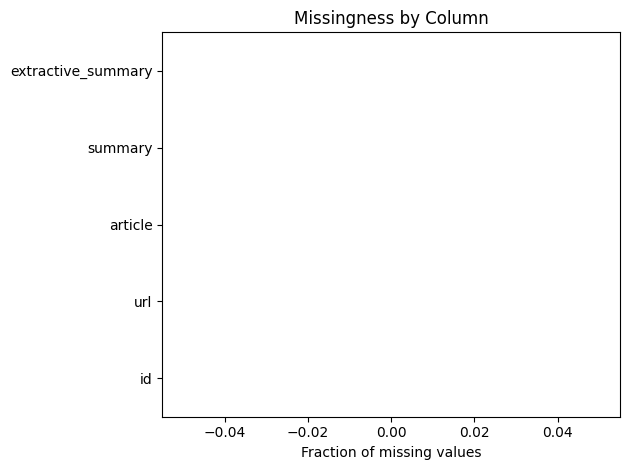

In [5]:

null_frac = df.isna().mean().sort_values(ascending=False)
display(null_frac.to_frame('null_fraction'))

# Plot null fraction
plt.figure()
null_frac.plot(kind='barh')
plt.xlabel('Fraction of missing values')
plt.title('Missingness by Column')
plt.tight_layout()
plt.show()


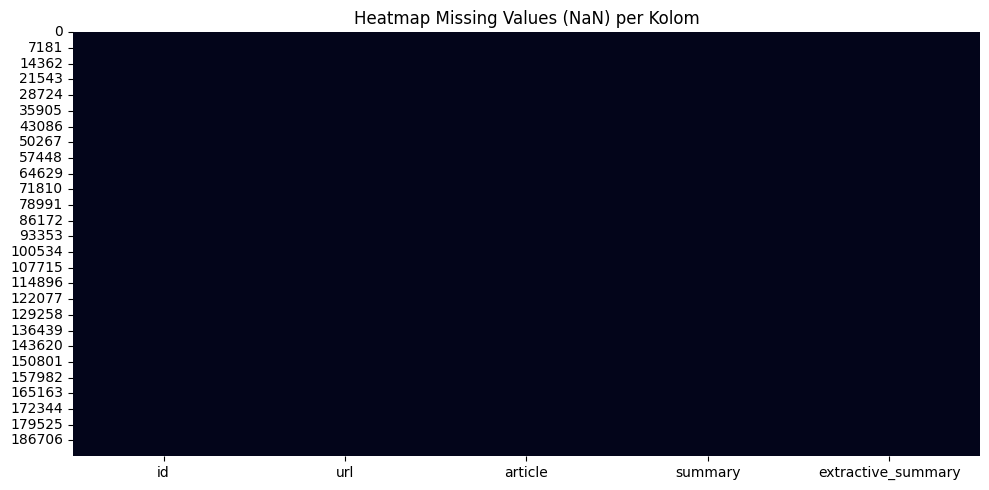

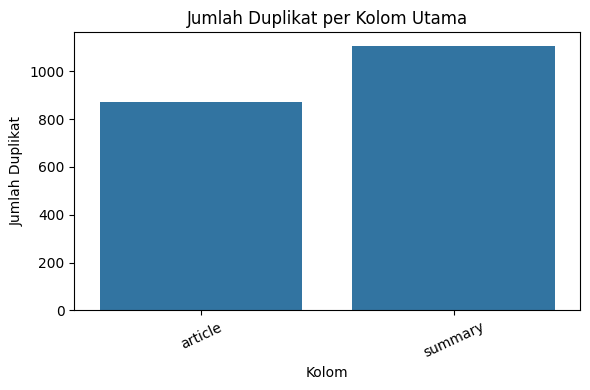

Jumlah duplikat artikel  : 871
Jumlah duplikat ringkasan: 1108


In [6]:
# ============================================================
# 🔍 Visualisasi Lanjutan: Missing Values & Duplikasi
# ============================================================
import seaborn as sns
import matplotlib.pyplot as plt

# Heatmap missing values
plt.figure(figsize=(10, 5))
sns.heatmap(df.isna(), cbar=False)
plt.title("Heatmap Missing Values (NaN) per Kolom")
plt.tight_layout()
plt.show()

# Jumlah duplikat berdasarkan kolom utama (gunakan kolom yang terdeteksi)
if article_col and article_col in df.columns:
    dup_article = df.duplicated(subset=[article_col]).sum()
else:
    dup_article = 0

if summary_col and summary_col in df.columns:
    dup_summary = df.duplicated(subset=[summary_col]).sum()
else:
    dup_summary = 0

# Buat DataFrame untuk visualisasi
dup_df = pd.DataFrame({
    'Kolom': [article_col or 'article', summary_col or 'summary'],
    'Jumlah Duplikat': [dup_article, dup_summary]
})

plt.figure(figsize=(6, 4))
sns.barplot(data=dup_df, x='Kolom', y='Jumlah Duplikat')
plt.title("Jumlah Duplikat per Kolom Utama")
plt.xticks(rotation=25)
plt.tight_layout()
plt.show()

print("Jumlah duplikat artikel  :", dup_article)
print("Jumlah duplikat ringkasan:", dup_summary)

<a id="step5"></a>

<a id="step6"></a>

## Langkah 5 — Distribusi Panjang Teks (Artikel & Ringkasan)

**📝 EDA Note:** Distribusi panjang teks mengungkapkan karakteristik dataset untuk model summarization. Panjang artikel dan ringkasan mempengaruhi arsitektur model (max sequence length) dan strategi padding/truncation.

Article length (words): mean/median/p90/max = 234.07 197.0 391.0 7379
Summary length (words): mean/median/p90/max = 30.99 30.0 39.0 102


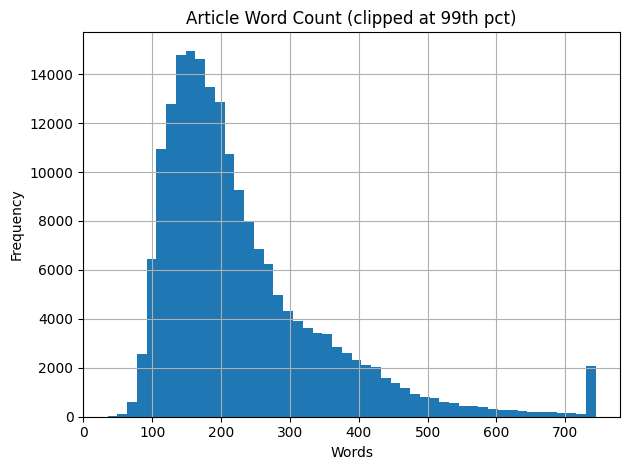

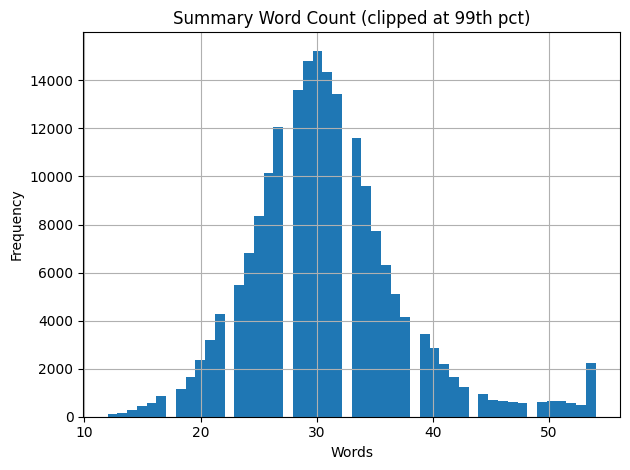

In [7]:

def count_words(s):
    if pd.isna(s): return 0
    return len(str(s).split())

if article_col and summary_col:
    art_len = df[article_col].apply(count_words)
    sum_len = df[summary_col].apply(count_words)

    print('Article length (words): mean/median/p90/max =',
          round(art_len.mean(),2), np.median(art_len), np.percentile(art_len,90), art_len.max())

    print('Summary length (words): mean/median/p90/max =',
          round(sum_len.mean(),2), np.median(sum_len), np.percentile(sum_len,90), sum_len.max())

    # Histograms
    plt.figure()
    art_len.clip(upper=np.percentile(art_len, 99)).hist(bins=50)
    plt.title('Article Word Count (clipped at 99th pct)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()

    plt.figure()
    sum_len.clip(upper=np.percentile(sum_len, 99)).hist(bins=50)
    plt.title('Summary Word Count (clipped at 99th pct)')
    plt.xlabel('Words'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()
else:
    print("Skip length distribution: no suitable article/summary column.")


<a id="step8"></a>

## Langkah 6 — Jumlah Kalimat per Artikel (Perkiraan)

**📝 EDA Note:** Jumlah kalimat per artikel membantu memahami kompleksitas struktur dokumen. Ini berguna untuk extractive summarization dan menentukan jumlah attention heads yang optimal.

Sentence count — mean/median/p90/max: 15.22 13.0 24.0 505


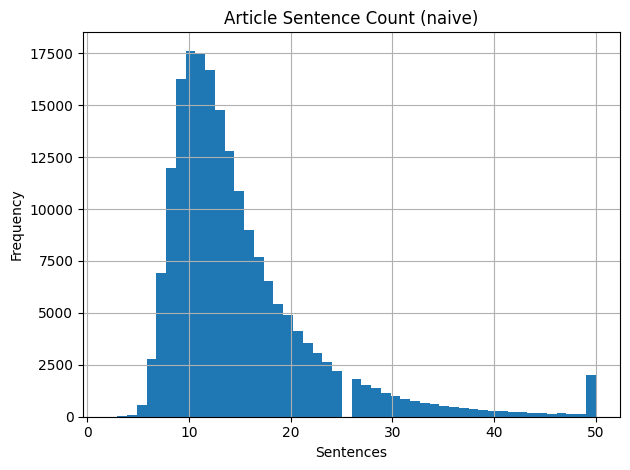

In [8]:

import re

def count_sentences(text):
    if pd.isna(text): return 0
    # naive split by punctuation . ! ? ; keeping it simple to avoid extra deps
    parts = re.split(r'[.!?;]+', str(text))
    # drop empties
    return len([p for p in parts if p.strip()!=''])

if article_col:
    sent_counts = df[article_col].apply(count_sentences)
    print('Sentence count — mean/median/p90/max:',
          round(sent_counts.mean(),2), np.median(sent_counts), np.percentile(sent_counts,90), sent_counts.max())

    plt.figure()
    sent_counts.clip(upper=np.percentile(sent_counts, 99)).hist(bins=50)
    plt.title('Article Sentence Count (naive)')
    plt.xlabel('Sentences'); plt.ylabel('Frequency')
    plt.tight_layout(); plt.show()


<a id="step9"></a>

## Langkah 7 — Contoh Artikel Terpendek & Terpanjang

**📝 EDA Note:** Melihat contoh ekstrem (terpendek/terpanjang) membantu mengidentifikasi edge cases dan potential outliers yang mungkin perlu penanganan khusus saat preprocessing.

In [9]:

if article_col and summary_col:
    # Show a few examples by length
    art_len = df[article_col].apply(lambda x: len(str(x).split()))
    idx_short = art_len.nsmallest(3).index
    idx_long  = art_len.nlargest(3).index

    print("\n=== Short Articles ===")
    display(df.loc[idx_short, [article_col, summary_col]].head(3))

    print("\n=== Long Articles ===")
    display(df.loc[idx_long, [article_col, summary_col]].head(3))



=== Short Articles ===


,article,summary
79703,Setelah tak terkalahkan dalam empat laga awal ...,Setelah tak terkalahkan dalam empat laga awal ...
73264,Keinginan Alan Curbishley untuk memboyong stri...,Keinginan Alan Curbishley untuk memboyong stri...
55156,"Memasuki musim kemarau , Warga Gunungpati , Se...","Memasuki musim kemarau , warga Gunungpati , Se..."



=== Long Articles ===


,article,summary
111871,"Liputan6 . com , Jakarta : Tim 8 yang dibentuk...",Tim 8 yang dibentuk presiden merekomendasikan ...
23208,"Karikatur Nabi Muhammad SAW Liputan6 . com , D...","Awal 2006 , dunia dikejutkan dengan munculnya ..."
181120,"Liputan6 . com , Jakarta : Diam itu emas . Per...",Putri sulung Presiden Pertama RI Soekarno itu ...


## Langkah 8 — Frekuensi Kata Umum (Most Common Words)
Analisis kata yang paling sering muncul pada kolom `clean_article_text`.


**📝 EDA Note:** Analisis frekuensi kata mengungkap tema dominan dalam dataset dan membantu memahami vocabulary distribution. WordCloud memberikan visualisasi intuitif tentang topik utama.

20 Kata Paling Umum (setelah menghapus stopwords):
liputan         209995
com             172111
jakarta         165737
tak             145309
tersebut        129534
warga           125640
tahun           95868
menjadi         94230
rumah           94024
baca            91720
hingga          83630
polisi          83049
satu            81798
indonesia       78025
sejumlah        77396
lebih           74964
tim             72716
korban          72409
pemerintah      70105
hari            69397


,Word,Frequency
0,liputan,209995
1,com,172111
2,jakarta,165737
3,tak,145309
4,tersebut,129534
5,warga,125640
6,tahun,95868
7,menjadi,94230
8,rumah,94024
9,baca,91720


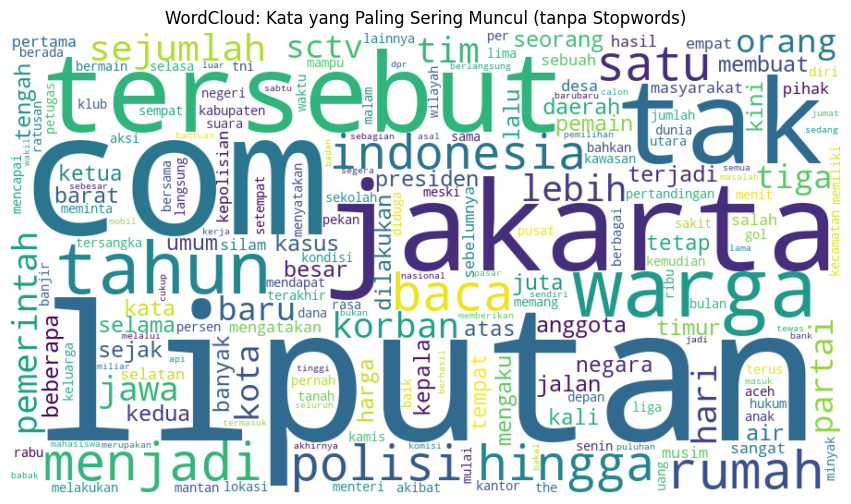

In [10]:
# ============================================================
# Langkah 8 — Frekuensi Kata Umum (Most Common Words)
# (dengan penghapusan stopwords Bahasa Indonesia)
# ============================================================

# !pip install -q wordcloud Sastrawi # Already installed earlier

import re
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import pandas as pd
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

# Gabungkan semua teks artikel dari kolom 'article'
# Convert to string and handle potential NaNs
text_data = " ".join(df['article'].dropna().astype(str)).lower()

# Hapus karakter non-alfabetik dan angka, tapi biarkan spasi
text_data = re.sub(r'[^a-zA-Z\s]', '', text_data)

# Tokenisasi sederhana berdasarkan spasi
tokens = text_data.split()

# Siapkan daftar stopwords Bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Filter stopwords dan kata pendek (panjang <= 2)
filtered_tokens = [t for t in tokens if t not in stopwords and len(t) > 2]

# Hitung frekuensi kata dari token yang sudah difilter
counter = Counter(filtered_tokens)
common_words = counter.most_common(20)

# Tampilkan 20 kata paling umum
print("20 Kata Paling Umum (setelah menghapus stopwords):")
for word, freq in common_words:
    print(f"{word:<15} {freq}")

# Konversi ke DataFrame untuk tampilan tabel
common_df = pd.DataFrame(common_words, columns=['Word', 'Frequency'])
display(common_df)

# Buat WordCloud dari frekuensi kata yang sudah difilter
wordcloud = WordCloud(
    width=900, height=500,
    background_color='white',
    max_words=200,
    colormap='viridis' # Use a colormap
).generate_from_frequencies(counter)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud: Kata yang Paling Sering Muncul (tanpa Stopwords)")
plt.show()

## Langkah 9 — Analisis Stopwords dalam Artikel

**📝 EDA Note:** Analisis stopwords penting untuk memahami struktur linguistik data. Untuk Seq2Seq, stopwords sering dihapus, namun untuk BERT transformer, stopwords tetap dipertahankan karena konteks penting.

20 Stopword Paling Sering Muncul dalam Artikel:
di              880970
yang            855936
dan             637067
ini             404784
itu             325920
dengan          303716
dari            303293
untuk           265706
dalam           218837
ke              193063
akan            186618
tidak           183986
juga            178893
mereka          164640
pada            134099
karena          123189
saat            113463
para            108576
masih           102437
dua             99451


,Stopword,Frequency
0,di,880970
1,yang,855936
2,dan,637067
3,ini,404784
4,itu,325920
5,dengan,303716
6,dari,303293
7,untuk,265706
8,dalam,218837
9,ke,193063


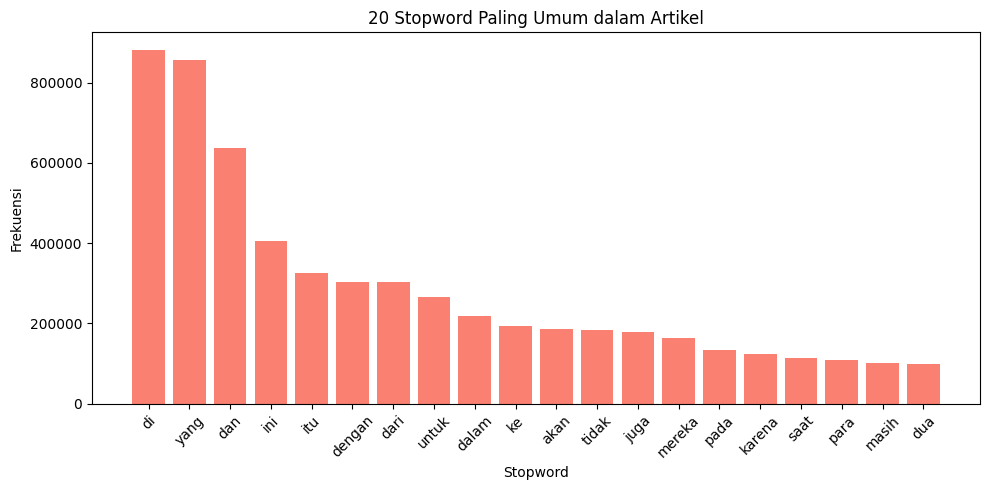

In [11]:
# ============================================================
# Langkah 9 — Analisis Stopwords dalam Artikel
# ============================================================

import matplotlib.pyplot as plt
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from collections import Counter
import pandas as pd
import re

# Gabungkan semua teks artikel
# Convert to string and handle potential NaNs
text_data = " ".join(df['article'].dropna().astype(str)).lower()

# Hapus karakter non-alfabetik dan angka, tapi biarkan spasi
text_data = re.sub(r'[^a-zA-Z\s]', ' ', text_data)
tokens = text_data.split()

# Siapkan stopword list Bahasa Indonesia
factory = StopWordRemoverFactory()
stopwords = set(factory.get_stop_words())

# Ambil hanya token yang merupakan stopwords
stopword_tokens = [t for t in tokens if t in stopwords]

# Hitung frekuensi stopword
stopword_counter = Counter(stopword_tokens)
common_stopwords = stopword_counter.most_common(20)

# Tampilkan 20 stopword paling umum
print("20 Stopword Paling Sering Muncul dalam Artikel:")
for word, freq in common_stopwords:
    print(f"{word:<15} {freq}")

# Tampilkan dalam bentuk tabel
stop_df = pd.DataFrame(common_stopwords, columns=['Stopword', 'Frequency'])
display(stop_df)

# Visualisasi dengan bar chart
plt.figure(figsize=(10,5))
plt.bar(stop_df['Stopword'], stop_df['Frequency'], color='salmon')
plt.title("20 Stopword Paling Umum dalam Artikel")
plt.xlabel("Stopword")
plt.ylabel("Frekuensi")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

---

# 🔧 PREPROCESSING UNTUK SEQ2SEQ & BERT TRANSFORMER

Bagian ini mempersiapkan data untuk training model **Seq2Seq** dan **BERT Transformer** dengan pipeline preprocessing yang komprehensif:

### Tujuan Preprocessing:
1. **Seq2Seq Models**: Memerlukan tokenisasi word-level, vocabulary encoding, dan sequence padding
2. **BERT Transformer**: Memerlukan tokenisasi subword (WordPiece), special tokens, dan attention masks

### Pipeline Preprocessing:
- **Data Cleaning**: HTML removal, special characters, normalization
- **Tokenization**: Word-level (Seq2Seq) dan Subword-level (BERT)
- **Stopword Removal**: Opsional untuk Seq2Seq, dipertahankan untuk BERT
- **Stemming**: Normalisasi kata dasar (Sastrawi)
- **Outlier Removal**: Deteksi dan filter data anomali
- **Encoding**: Vocabulary mapping dan sequence encoding
- **Validation**: Train/val/test split dan quality checks

## Langkah 10 — Data Cleaning (Pembersihan Data)

**Tujuan**: Menghapus HTML tags, special characters, multiple whitespaces, dan normalize text.

In [12]:
# ============================================================
# Langkah 10 — Data Cleaning
# ============================================================

import re
import html
from bs4 import BeautifulSoup

def clean_text(text):
    """
    Comprehensive text cleaning function
    - Remove HTML tags
    - Decode HTML entities
    - Remove URLs
    - Remove email addresses
    - Remove extra whitespaces
    - Normalize punctuation
    """
    if pd.isna(text) or text == '':
        return ''
    
    text = str(text)
    
    # Decode HTML entities (e.g., &amp; -> &)
    text = html.unescape(text)
    
    # Remove HTML tags using BeautifulSoup
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text(separator=' ')
    
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    
    # Remove email addresses
    text = re.sub(r'\S+@\S+', '', text)
    
    # Remove extra whitespaces, tabs, newlines
    text = re.sub(r'\s+', ' ', text)
    
    # Remove leading/trailing whitespace
    text = text.strip()
    
    # Normalize quotes
    text = text.replace('"', '"').replace('"', '"')
    text = text.replace(''', "'").replace(''', "'")
    
    return text

# Apply cleaning to both article and summary columns
print("🧹 Cleaning data...")
if article_col and article_col in df.columns:
    df['clean_article'] = df[article_col].apply(clean_text)
    print(f"✓ Cleaned {article_col}")

if summary_col and summary_col in df.columns:
    df['clean_summary'] = df[summary_col].apply(clean_text)
    print(f"✓ Cleaned {summary_col}")

# Remove rows with empty text after cleaning
initial_rows = len(df)
df = df[(df['clean_article'].str.len() > 0) & (df['clean_summary'].str.len() > 0)]
print(f"✓ Removed {initial_rows - len(df)} empty rows after cleaning")
print(f"✓ Remaining rows: {len(df)}")

# Display sample cleaned data
print("\n📋 Sample Cleaned Data:")
display(df[['clean_article', 'clean_summary']].head(3))

🧹 Cleaning data...
✓ Cleaned article
✓ Cleaned article
✓ Cleaned summary
✓ Removed 0 empty rows after cleaning
✓ Remaining rows: 193883

📋 Sample Cleaned Data:
✓ Cleaned summary
✓ Removed 0 empty rows after cleaning
✓ Remaining rows: 193883

📋 Sample Cleaned Data:


,clean_article,clean_summary
0,"Liputan6 . com , Jakarta : Presiden Susilo Bam...","Menurut Presiden Susilo Bambang Yudhoyono , ke..."
1,"Liputan6 . com , Jakarta : Perdana Menteri Jep...",Pada masa silam Jepang terlalu ambisius untuk ...
2,"Liputan6 . com , Kutai : Banjir dengan ketingg...",Puluhan hektare areal persawahan yang sebagian...


## Langkah 11 — Remove Duplicates

**Tujuan**: Menghapus artikel yang duplikat untuk menghindari data leakage antara train/val/test sets.

In [13]:
# ============================================================
# Langkah 11 — Remove Duplicates
# ============================================================

print("🔍 Checking for duplicates...")
initial_rows = len(df)

# Check duplicates in clean_article
dup_articles = df.duplicated(subset=['clean_article'], keep='first').sum()
print(f"Found {dup_articles} duplicate articles")

# Remove duplicates based on article content
df = df.drop_duplicates(subset=['clean_article'], keep='first')

# Also check if same article has different summaries (keep first occurrence)
print(f"✓ Removed {initial_rows - len(df)} duplicate rows")
print(f"✓ Remaining rows: {len(df)}")

# Reset index
df = df.reset_index(drop=True)

🔍 Checking for duplicates...
Found 871 duplicate articles
✓ Removed 871 duplicate rows
✓ Remaining rows: 193012
✓ Removed 871 duplicate rows
✓ Remaining rows: 193012


## Langkah 12 — Tokenization (Word-level untuk Seq2Seq)

**Tujuan**: Tokenisasi berbasis kata untuk model Seq2Seq tradisional.

In [14]:
# ============================================================
# Langkah 12 — Tokenization (Word-level untuk Seq2Seq)
# ============================================================

import re

def simple_tokenize(text):
    """
    Simple word tokenization for Indonesian text
    Preserves words and basic punctuation
    """
    if pd.isna(text) or text == '':
        return []
    
    text = str(text).lower()
    
    # Split by whitespace and punctuation but keep words
    tokens = re.findall(r'\b\w+\b', text)
    
    return tokens

# Tokenize articles and summaries
print("📝 Tokenizing text (word-level)...")
df['tokens_article'] = df['clean_article'].apply(simple_tokenize)
df['tokens_summary'] = df['clean_summary'].apply(simple_tokenize)

# Calculate token counts
df['num_tokens_article'] = df['tokens_article'].apply(len)
df['num_tokens_summary'] = df['tokens_summary'].apply(len)

print(f"✓ Tokenization complete")
print(f"📊 Article tokens — Mean: {df['num_tokens_article'].mean():.1f}, Median: {df['num_tokens_article'].median():.0f}")
print(f"📊 Summary tokens — Mean: {df['num_tokens_summary'].mean():.1f}, Median: {df['num_tokens_summary'].median():.0f}")

# Display sample
print("\n📋 Sample Tokenized Data:")
sample_idx = 0
print(f"Article tokens ({df.loc[sample_idx, 'num_tokens_article']} tokens):")
print(df.loc[sample_idx, 'tokens_article'][:50])
print(f"\nSummary tokens ({df.loc[sample_idx, 'num_tokens_summary']} tokens):")
print(df.loc[sample_idx, 'tokens_summary'][:30])

📝 Tokenizing text (word-level)...
✓ Tokenization complete
📊 Article tokens — Mean: 199.9, Median: 168
📊 Summary tokens — Mean: 27.4, Median: 27

📋 Sample Tokenized Data:
Article tokens (296 tokens):
['liputan6', 'com', 'jakarta', 'presiden', 'susilo', 'bambang', 'yudhoyono', 'menekankan', 'bahwa', 'tantangan', 'terbesar', 'yang', 'dihadapi', 'bangsa', 'bangsa', 'asia', 'dan', 'afrika', 'saat', 'ini', 'adalah', 'masalah', 'kemiskinan', 'yang', 'sangat', 'buruk', 'yudhoyono', 'berharap', 'masalah', 'ini', 'menjadi', 'pembahasan', 'penting', 'dalam', 'konferensi', 'tingkat', 'tinggi', 'asia', 'afrika', 'demikian', 'pidato', 'yudhoyono', 'saat', 'membuka', 'ktt', 'asia', 'afrika', 'di', 'jakarta', 'convention']

Summary tokens (28 tokens):
['menurut', 'presiden', 'susilo', 'bambang', 'yudhoyono', 'kemiskinan', 'kini', 'menjadi', 'masalah', 'serius', 'yang', 'dihadapi', 'bangsa', 'bangsa', 'di', 'asia', 'dan', 'afrika', 'diharapkan', 'masalah', 'ini', 'menjadi', 'agenda', 'penting', 'dalam'

## Langkah 13 — Stopword Removal & Stemming (untuk Seq2Seq)

**Tujuan**: 
- Menghapus stopwords untuk mengurangi noise (opsional untuk Seq2Seq)
- Stemming untuk normalisasi kata ke bentuk dasar

**Note**: Untuk BERT, kita akan skip langkah ini karena konteks penting untuk transformer.

In [15]:
# ============================================================
# Langkah 13 — Stopword Removal & Stemming (untuk Seq2Seq)
# ============================================================

from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Initialize stopword remover and stemmer
stopword_factory = StopWordRemoverFactory()
stopwords = set(stopword_factory.get_stop_words())

stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()

def remove_stopwords(tokens):
    """Remove stopwords from token list"""
    return [token for token in tokens if token not in stopwords]

def stem_tokens(tokens):
    """Apply stemming to each token"""
    return [stemmer.stem(token) for token in tokens]

# Option 1: For Seq2Seq - Remove stopwords and apply stemming
print("🔧 Preprocessing for Seq2Seq (stopword removal + stemming)...")
df['tokens_seq2seq_article'] = df['tokens_article'].apply(remove_stopwords).apply(stem_tokens)
df['tokens_seq2seq_summary'] = df['tokens_summary'].apply(remove_stopwords).apply(stem_tokens)

df['num_tokens_seq2seq_article'] = df['tokens_seq2seq_article'].apply(len)
df['num_tokens_seq2seq_summary'] = df['tokens_seq2seq_summary'].apply(len)

print(f"✓ Seq2Seq preprocessing complete")
print(f"📊 Seq2Seq Article tokens — Mean: {df['num_tokens_seq2seq_article'].mean():.1f}")
print(f"📊 Seq2Seq Summary tokens — Mean: {df['num_tokens_seq2seq_summary'].mean():.1f}")

# Option 2: For BERT - Keep original tokens (no stopword removal)
print("\n🤖 Preprocessing for BERT (preserving all tokens)...")
df['tokens_bert_article'] = df['tokens_article'].copy()
df['tokens_bert_summary'] = df['tokens_summary'].copy()
print("✓ BERT tokens preserved (no stopword removal)")

# Compare example
print("\n📋 Comparison Example:")
sample_idx = 0
print(f"Original tokens ({len(df.loc[sample_idx, 'tokens_article'])}): {df.loc[sample_idx, 'tokens_article'][:30]}")
print(f"Seq2Seq tokens ({len(df.loc[sample_idx, 'tokens_seq2seq_article'])}): {df.loc[sample_idx, 'tokens_seq2seq_article'][:30]}")
print(f"BERT tokens ({len(df.loc[sample_idx, 'tokens_bert_article'])}): {df.loc[sample_idx, 'tokens_bert_article'][:30]}")

🔧 Preprocessing for Seq2Seq (stopword removal + stemming)...
✓ Seq2Seq preprocessing complete
📊 Seq2Seq Article tokens — Mean: 155.7
📊 Seq2Seq Summary tokens — Mean: 22.2

🤖 Preprocessing for BERT (preserving all tokens)...
✓ BERT tokens preserved (no stopword removal)

📋 Comparison Example:
Original tokens (296): ['liputan6', 'com', 'jakarta', 'presiden', 'susilo', 'bambang', 'yudhoyono', 'menekankan', 'bahwa', 'tantangan', 'terbesar', 'yang', 'dihadapi', 'bangsa', 'bangsa', 'asia', 'dan', 'afrika', 'saat', 'ini', 'adalah', 'masalah', 'kemiskinan', 'yang', 'sangat', 'buruk', 'yudhoyono', 'berharap', 'masalah', 'ini']
Seq2Seq tokens (226): ['liputan6', 'com', 'jakarta', 'presiden', 'susilo', 'bambang', 'yudhoyono', 'tekan', 'tantang', 'besar', 'hadap', 'bangsa', 'bangsa', 'asia', 'afrika', 'masalah', 'miskin', 'sangat', 'buruk', 'yudhoyono', 'harap', 'masalah', 'jadi', 'bahas', 'penting', 'konferensi', 'tingkat', 'tinggi', 'asia', 'afrika']
BERT tokens (296): ['liputan6', 'com', 'jakar

## Langkah 14 — Noise & Outlier Detection/Removal

**Tujuan**: Mendeteksi dan menghapus data berkualitas rendah atau anomali:
- Artikel terlalu pendek atau terlalu panjang
- Ringkasan yang tidak proporsional
- Text dengan rasio karakter/token abnormal

🔍 Detecting outliers and low-quality data...
📏 Thresholds:
  Article: 50 - 641 tokens
  Summary: 5 - 45 tokens

📊 Outlier Removal Results:
  Rows removed by article length: 2010
  Rows removed by summary length: 1728
  Rows removed by compression ratio: 3434
  Rows removed by diversity: 13
  Total rows removed: 5211
  ✓ Remaining rows: 187801 (97.3%)

📊 Outlier Removal Results:
  Rows removed by article length: 2010
  Rows removed by summary length: 1728
  Rows removed by compression ratio: 3434
  Rows removed by diversity: 13
  Total rows removed: 5211
  ✓ Remaining rows: 187801 (97.3%)


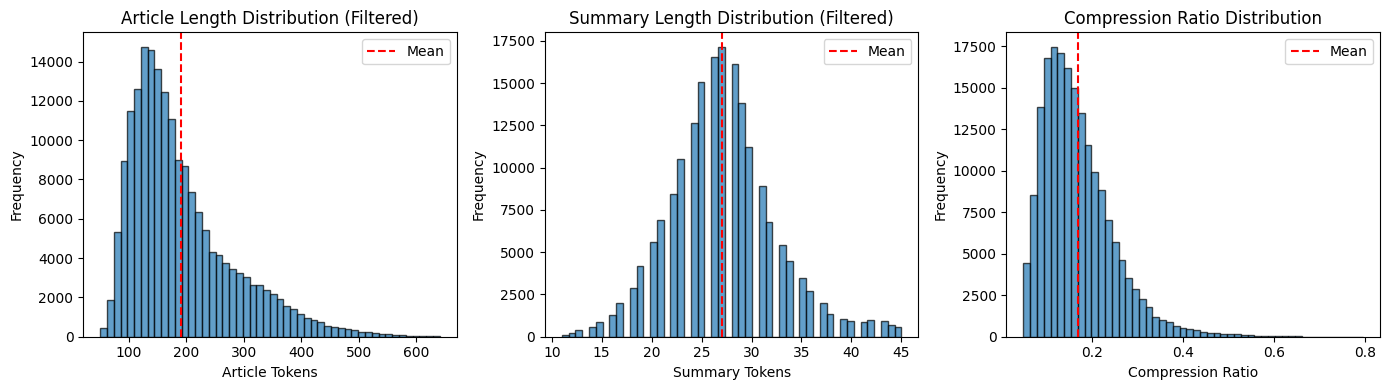

In [16]:
# ============================================================
# Langkah 14 — Noise & Outlier Detection/Removal
# ============================================================

import numpy as np

print("🔍 Detecting outliers and low-quality data...")
initial_rows = len(df)

# Define thresholds based on percentiles
article_min_tokens = 50  # Minimum article length
article_max_tokens = int(np.percentile(df['num_tokens_article'], 99))  # 99th percentile
summary_min_tokens = 5   # Minimum summary length
summary_max_tokens = int(np.percentile(df['num_tokens_summary'], 99))  # 99th percentile

print(f"📏 Thresholds:")
print(f"  Article: {article_min_tokens} - {article_max_tokens} tokens")
print(f"  Summary: {summary_min_tokens} - {summary_max_tokens} tokens")

# Filter based on length
mask_article_length = (df['num_tokens_article'] >= article_min_tokens) & \
                      (df['num_tokens_article'] <= article_max_tokens)
mask_summary_length = (df['num_tokens_summary'] >= summary_min_tokens) & \
                      (df['num_tokens_summary'] <= summary_max_tokens)

# Check compression ratio (summary should be shorter than article)
df['compression_ratio'] = df['num_tokens_summary'] / df['num_tokens_article']
mask_compression = (df['compression_ratio'] > 0.05) & (df['compression_ratio'] < 0.8)

# Check for repetitive text (low unique token ratio)
df['unique_ratio_article'] = df['tokens_article'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
df['unique_ratio_summary'] = df['tokens_summary'].apply(lambda x: len(set(x)) / len(x) if len(x) > 0 else 0)
mask_diversity = (df['unique_ratio_article'] > 0.3) & (df['unique_ratio_summary'] > 0.3)

# Combine all filters
final_mask = mask_article_length & mask_summary_length & mask_compression & mask_diversity

# Apply filter
df_filtered = df[final_mask].copy()
df_filtered = df_filtered.reset_index(drop=True)

print(f"\n📊 Outlier Removal Results:")
print(f"  Rows removed by article length: {(~mask_article_length).sum()}")
print(f"  Rows removed by summary length: {(~mask_summary_length).sum()}")
print(f"  Rows removed by compression ratio: {(~mask_compression).sum()}")
print(f"  Rows removed by diversity: {(~mask_diversity).sum()}")
print(f"  Total rows removed: {initial_rows - len(df_filtered)}")
print(f"  ✓ Remaining rows: {len(df_filtered)} ({len(df_filtered)/initial_rows*100:.1f}%)")

# Visualize distributions after filtering
plt.figure(figsize=(14, 4))

plt.subplot(1, 3, 1)
plt.hist(df_filtered['num_tokens_article'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Article Tokens')
plt.ylabel('Frequency')
plt.title('Article Length Distribution (Filtered)')
plt.axvline(df_filtered['num_tokens_article'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1, 3, 2)
plt.hist(df_filtered['num_tokens_summary'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Summary Tokens')
plt.ylabel('Frequency')
plt.title('Summary Length Distribution (Filtered)')
plt.axvline(df_filtered['num_tokens_summary'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(df_filtered['compression_ratio'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Compression Ratio')
plt.ylabel('Frequency')
plt.title('Compression Ratio Distribution')
plt.axvline(df_filtered['compression_ratio'].mean(), color='red', linestyle='--', label='Mean')
plt.legend()

plt.tight_layout()
plt.show()

# Update df with filtered data
df = df_filtered.copy()

## Langkah 15 — BERT Tokenization (Subword-level)

**Tujuan**: Menggunakan BERT tokenizer untuk subword tokenization dengan IndoBERT atau multilingual BERT.

**Note**: Install transformers library jika belum tersedia.

In [ ]:
# Uncomment baris di bawah untuk instalasi manual transformers
# !pip install -q transformers torch sentencepiece

**💡 Catatan Instalasi:**

Jika cell berikutnya gagal dengan error `ModuleNotFoundError`, jalankan perintah ini di terminal:

```bash
pip install transformers torch sentencepiece
```

Atau uncomment dan jalankan cell di bawah ini untuk instalasi manual.

In [22]:
# ============================================================
# Langkah 15 — BERT Tokenization (Subword-level)
# ============================================================

# Install transformers if not already installed
import sys
import subprocess

try:
    from transformers import BertTokenizer, AutoTokenizer
    print("✓ transformers library already installed")
except ImportError:
    print("📦 Installing transformers library...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "transformers"])
    from transformers import BertTokenizer, AutoTokenizer
    print("✓ transformers library installed successfully")

# Use IndoBERT for Indonesian language or mBERT for multilingual
# IndoBERT: "indolem/indobert-base-uncased"
# mBERT: "bert-base-multilingual-cased"

print("\n🤖 Loading BERT tokenizer...")
tokenizer_name = "indolem/indobert-base-uncased"  # Change to your preferred model

try:
    bert_tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
    print(f"✓ Loaded tokenizer: {tokenizer_name}")
except Exception as e:
    print(f"⚠️  Could not load {tokenizer_name}")
    print(f"   Error: {str(e)}")
    print("   Trying with mBERT instead...")
    try:
        tokenizer_name = "bert-base-multilingual-cased"
        bert_tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)
        print(f"✓ Loaded tokenizer: {tokenizer_name}")
    except Exception as e2:
        print(f"❌ Failed to load mBERT: {str(e2)}")
        print("\n💡 Solutions:")
        print("   1. Check your internet connection")
        print("   2. Try running: pip install transformers torch")
        print("   3. Manually download tokenizer if offline")
        raise

# Set maximum sequence lengths
MAX_ARTICLE_LENGTH = 512  # BERT max is 512, but you can adjust
MAX_SUMMARY_LENGTH = 128

print(f"\n📏 Max sequence lengths:")
print(f"  Article: {MAX_ARTICLE_LENGTH}")
print(f"  Summary: {MAX_SUMMARY_LENGTH}")

# Check if we have data to tokenize
if len(df) == 0:
    print("\n⚠️  Warning: DataFrame is empty. Please run previous cells first.")
else:
    # Tokenize a sample to demonstrate
    sample_idx = 0
    sample_article = df.loc[sample_idx, 'clean_article']
    sample_summary = df.loc[sample_idx, 'clean_summary']

    # Tokenize with BERT tokenizer (using numpy arrays instead of PyTorch tensors)
    try:
        article_encoding = bert_tokenizer(
            sample_article,
            max_length=MAX_ARTICLE_LENGTH,
            truncation=True,
            padding='max_length',
            return_tensors='np'  # Use numpy arrays instead of PyTorch tensors
        )

        summary_encoding = bert_tokenizer(
            sample_summary,
            max_length=MAX_SUMMARY_LENGTH,
            truncation=True,
            padding='max_length',
            return_tensors='np'  # Use numpy arrays instead of PyTorch tensors
        )

        print(f"\n📋 Sample BERT Tokenization:")
        print(f"Article - Original: {sample_article[:100]}...")
        print(f"Article - Token IDs shape: {article_encoding['input_ids'].shape}")
        print(f"Article - Attention mask shape: {article_encoding['attention_mask'].shape}")
        print(f"Article - First 20 token IDs: {article_encoding['input_ids'][0][:20].tolist()}")

        print(f"\nSummary - Original: {sample_summary[:100]}...")
        print(f"Summary - Token IDs shape: {summary_encoding['input_ids'].shape}")
        print(f"Summary - Attention mask shape: {summary_encoding['attention_mask'].shape}")

        # Decode back to verify
        decoded_article = bert_tokenizer.decode(article_encoding['input_ids'][0], skip_special_tokens=True)
        print(f"\nDecoded article (first 100 chars): {decoded_article[:100]}...")
        
        print("\n✅ BERT tokenization successful!")
        print("\n💡 Note: Using numpy arrays. Install PyTorch for better performance:")
        print("   pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118")
        
    except Exception as e:
        print(f"\n❌ Error during tokenization: {str(e)}")
        print("\n💡 Troubleshooting:")
        print("   1. Check if data is properly cleaned in previous steps")
        print("   2. Verify transformers library is installed: pip install transformers")
        print("   3. For PyTorch support: pip install torch")

✓ transformers library already installed

🤖 Loading BERT tokenizer...
✓ Loaded tokenizer: indolem/indobert-base-uncased

📏 Max sequence lengths:
  Article: 512
  Summary: 128

📋 Sample BERT Tokenization:
Article - Original: Liputan6 . com , Jakarta : Presiden Susilo Bambang Yudhoyono menekankan bahwa tantangan terbesar yan...
Article - Token IDs shape: (1, 512)
Article - Attention mask shape: (1, 512)
Article - First 20 token IDs: [3, 21666, 18, 2589, 16, 1892, 30, 2134, 5662, 4276, 5107, 7679, 1737, 6609, 3677, 1497, 8051, 2417, 17, 2417]

Summary - Original: Menurut Presiden Susilo Bambang Yudhoyono , kemiskinan kini menjadi masalah serius yang dihadapi ban...
Summary - Token IDs shape: (1, 128)
Summary - Attention mask shape: (1, 128)

Decoded article (first 100 chars): liputan6. com, jakarta : presiden susilo bambang yudhoyono menekankan bahwa tantangan terbesar yang ...

✅ BERT tokenization successful!

💡 Note: Using numpy arrays. Install PyTorch for better performance:
   pip ins

## Langkah 16 — Build Vocabulary & Encoding (untuk Seq2Seq)

**Tujuan**: Membuat vocabulary dari token dan encode sequences untuk model Seq2Seq.

In [23]:
# ============================================================
# Langkah 16 — Build Vocabulary & Encoding (untuk Seq2Seq)
# ============================================================

from collections import Counter

print("📚 Building vocabulary for Seq2Seq...")

# Special tokens
PAD_TOKEN = '<PAD>'
UNK_TOKEN = '<UNK>'
SOS_TOKEN = '<SOS>'  # Start of sequence
EOS_TOKEN = '<EOS>'  # End of sequence

# Collect all tokens from articles and summaries
all_tokens = []
for tokens in df['tokens_seq2seq_article']:
    all_tokens.extend(tokens)
for tokens in df['tokens_seq2seq_summary']:
    all_tokens.extend(tokens)

# Count token frequencies
token_freq = Counter(all_tokens)
print(f"✓ Total unique tokens: {len(token_freq)}")

# Filter vocabulary by minimum frequency
MIN_FREQ = 2  # Minimum token frequency to include in vocabulary
vocab_tokens = [token for token, freq in token_freq.items() if freq >= MIN_FREQ]

# Build word to index mapping
word2idx = {PAD_TOKEN: 0, UNK_TOKEN: 1, SOS_TOKEN: 2, EOS_TOKEN: 3}
for idx, token in enumerate(vocab_tokens, start=4):
    word2idx[token] = idx

# Build index to word mapping
idx2word = {idx: word for word, idx in word2idx.items()}

vocab_size = len(word2idx)
print(f"✓ Vocabulary size (with special tokens): {vocab_size}")
print(f"  Special tokens: {PAD_TOKEN}={word2idx[PAD_TOKEN]}, {UNK_TOKEN}={word2idx[UNK_TOKEN]}, {SOS_TOKEN}={word2idx[SOS_TOKEN]}, {EOS_TOKEN}={word2idx[EOS_TOKEN]}")

# Function to encode tokens to indices
def encode_tokens(tokens, word2idx, add_sos=False, add_eos=False):
    """Convert tokens to indices using vocabulary"""
    encoded = []
    if add_sos:
        encoded.append(word2idx[SOS_TOKEN])
    
    for token in tokens:
        encoded.append(word2idx.get(token, word2idx[UNK_TOKEN]))
    
    if add_eos:
        encoded.append(word2idx[EOS_TOKEN])
    
    return encoded

# Encode articles and summaries
print("\n🔢 Encoding sequences...")
df['encoded_article'] = df['tokens_seq2seq_article'].apply(
    lambda x: encode_tokens(x, word2idx, add_sos=False, add_eos=False)
)
df['encoded_summary'] = df['tokens_seq2seq_summary'].apply(
    lambda x: encode_tokens(x, word2idx, add_sos=True, add_eos=True)
)

# Calculate encoded lengths
df['encoded_article_len'] = df['encoded_article'].apply(len)
df['encoded_summary_len'] = df['encoded_summary'].apply(len)

print(f"✓ Sequences encoded")
print(f"📊 Encoded article length — Mean: {df['encoded_article_len'].mean():.1f}, Max: {df['encoded_article_len'].max()}")
print(f"📊 Encoded summary length — Mean: {df['encoded_summary_len'].mean():.1f}, Max: {df['encoded_summary_len'].max()}")

# Display sample encoding
print("\n📋 Sample Encoding:")
sample_idx = 0
print(f"Original tokens: {df.loc[sample_idx, 'tokens_seq2seq_summary'][:10]}")
print(f"Encoded indices: {df.loc[sample_idx, 'encoded_summary'][:12]}")
print(f"Decoded tokens: {[idx2word[idx] for idx in df.loc[sample_idx, 'encoded_summary'][:12]]}")

📚 Building vocabulary for Seq2Seq...
✓ Total unique tokens: 206267
✓ Vocabulary size (with special tokens): 114793
  Special tokens: <PAD>=0, <UNK>=1, <SOS>=2, <EOS>=3

🔢 Encoding sequences...
✓ Total unique tokens: 206267
✓ Vocabulary size (with special tokens): 114793
  Special tokens: <PAD>=0, <UNK>=1, <SOS>=2, <EOS>=3

🔢 Encoding sequences...
✓ Sequences encoded
📊 Encoded article length — Mean: 148.8, Max: 550
📊 Encoded summary length — Mean: 23.9, Max: 45

📋 Sample Encoding:
Original tokens: ['presiden', 'susilo', 'bambang', 'yudhoyono', 'miskin', 'kini', 'jadi', 'masalah', 'serius', 'hadap']
Encoded indices: [2, 7, 8, 9, 10, 19, 290, 23, 18, 2228, 14, 15]
Decoded tokens: ['<SOS>', 'presiden', 'susilo', 'bambang', 'yudhoyono', 'miskin', 'kini', 'jadi', 'masalah', 'serius', 'hadap', 'bangsa']
✓ Sequences encoded
📊 Encoded article length — Mean: 148.8, Max: 550
📊 Encoded summary length — Mean: 23.9, Max: 45

📋 Sample Encoding:
Original tokens: ['presiden', 'susilo', 'bambang', 'yudh

## Langkah 17 — Padding & Sequence Preparation

**Tujuan**: Padding sequences ke panjang yang sama untuk batch processing.

In [24]:
# ============================================================
# Langkah 17 — Padding & Sequence Preparation
# ============================================================

import numpy as np

# Determine max lengths based on percentiles to avoid extreme outliers
MAX_ARTICLE_SEQ_LEN = int(np.percentile(df['encoded_article_len'], 95))
MAX_SUMMARY_SEQ_LEN = int(np.percentile(df['encoded_summary_len'], 95))

print(f"📏 Maximum sequence lengths (95th percentile):")
print(f"  Article: {MAX_ARTICLE_SEQ_LEN}")
print(f"  Summary: {MAX_SUMMARY_SEQ_LEN}")

def pad_sequence(sequence, max_len, pad_value=0):
    """Pad or truncate sequence to max_len"""
    if len(sequence) >= max_len:
        return sequence[:max_len]
    else:
        return sequence + [pad_value] * (max_len - len(sequence))

# Apply padding to encoded sequences
print("\n🔧 Padding sequences...")
df['padded_article'] = df['encoded_article'].apply(
    lambda x: pad_sequence(x, MAX_ARTICLE_SEQ_LEN, pad_value=word2idx[PAD_TOKEN])
)
df['padded_summary'] = df['encoded_summary'].apply(
    lambda x: pad_sequence(x, MAX_SUMMARY_SEQ_LEN, pad_value=word2idx[PAD_TOKEN])
)

print(f"✓ Sequences padded")

# Verify padding
sample_idx = 0
print(f"\n📋 Padding Verification:")
print(f"Original article length: {len(df.loc[sample_idx, 'encoded_article'])}")
print(f"Padded article length: {len(df.loc[sample_idx, 'padded_article'])}")
print(f"Original summary length: {len(df.loc[sample_idx, 'encoded_summary'])}")
print(f"Padded summary length: {len(df.loc[sample_idx, 'padded_summary'])}")
print(f"\nPadded article (last 10 tokens): {df.loc[sample_idx, 'padded_article'][-10:]}")
print(f"Padded summary (last 10 tokens): {df.loc[sample_idx, 'padded_summary'][-10:]}")

# Create numpy arrays for model training
print("\n🔢 Converting to numpy arrays...")
X_seq2seq = np.array(df['padded_article'].tolist())
y_seq2seq = np.array(df['padded_summary'].tolist())

print(f"✓ X_seq2seq shape: {X_seq2seq.shape}")
print(f"✓ y_seq2seq shape: {y_seq2seq.shape}")

📏 Maximum sequence lengths (95th percentile):
  Article: 288
  Summary: 32

🔧 Padding sequences...
✓ Sequences padded

📋 Padding Verification:
Original article length: 226
Padded article length: 288
Original summary length: 24
Padded summary length: 32

Padded article (last 10 tokens): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded summary (last 10 tokens): [17, 3, 0, 0, 0, 0, 0, 0, 0, 0]

🔢 Converting to numpy arrays...
✓ X_seq2seq shape: (187801, 288)
✓ y_seq2seq shape: (187801, 32)
✓ Sequences padded

📋 Padding Verification:
Original article length: 226
Padded article length: 288
Original summary length: 24
Padded summary length: 32

Padded article (last 10 tokens): [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Padded summary (last 10 tokens): [17, 3, 0, 0, 0, 0, 0, 0, 0, 0]

🔢 Converting to numpy arrays...
✓ X_seq2seq shape: (187801, 288)
✓ y_seq2seq shape: (187801, 32)


## Langkah 18 — Train/Validation/Test Split

**Tujuan**: Membagi dataset menjadi train, validation, dan test sets dengan stratifikasi.

In [25]:
# ============================================================
# Langkah 18 — Train/Validation/Test Split
# ============================================================

from sklearn.model_selection import train_test_split

# Define split ratios
TRAIN_RATIO = 0.7
VAL_RATIO = 0.15
TEST_RATIO = 0.15

print(f"📊 Split ratios: Train={TRAIN_RATIO}, Val={VAL_RATIO}, Test={TEST_RATIO}")

# First split: separate train from temp (val + test)
train_df, temp_df = train_test_split(
    df, 
    test_size=(VAL_RATIO + TEST_RATIO),
    random_state=42,
    shuffle=True
)

# Second split: separate val from test
val_df, test_df = train_test_split(
    temp_df,
    test_size=TEST_RATIO/(VAL_RATIO + TEST_RATIO),
    random_state=42,
    shuffle=True
)

# Reset indices
train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print(f"\n✓ Data split complete:")
print(f"  Train set: {len(train_df)} samples ({len(train_df)/len(df)*100:.1f}%)")
print(f"  Val set: {len(val_df)} samples ({len(val_df)/len(df)*100:.1f}%)")
print(f"  Test set: {len(test_df)} samples ({len(test_df)/len(df)*100:.1f}%)")
print(f"  Total: {len(train_df) + len(val_df) + len(test_df)} samples")

# Verify statistics across splits
print(f"\n📊 Article length statistics across splits:")
print(f"  Train — Mean: {train_df['num_tokens_article'].mean():.1f}, Median: {train_df['num_tokens_article'].median():.0f}")
print(f"  Val   — Mean: {val_df['num_tokens_article'].mean():.1f}, Median: {val_df['num_tokens_article'].median():.0f}")
print(f"  Test  — Mean: {test_df['num_tokens_article'].mean():.1f}, Median: {test_df['num_tokens_article'].median():.0f}")

print(f"\n📊 Summary length statistics across splits:")
print(f"  Train — Mean: {train_df['num_tokens_summary'].mean():.1f}, Median: {train_df['num_tokens_summary'].median():.0f}")
print(f"  Val   — Mean: {val_df['num_tokens_summary'].mean():.1f}, Median: {val_df['num_tokens_summary'].median():.0f}")
print(f"  Test  — Mean: {test_df['num_tokens_summary'].mean():.1f}, Median: {test_df['num_tokens_summary'].median():.0f}")

📊 Split ratios: Train=0.7, Val=0.15, Test=0.15

✓ Data split complete:
  Train set: 131460 samples (70.0%)
  Val set: 28170 samples (15.0%)
  Test set: 28171 samples (15.0%)
  Total: 187801 samples

📊 Article length statistics across splits:
  Train — Mean: 190.8, Median: 166
  Val   — Mean: 191.0, Median: 167
  Test  — Mean: 190.7, Median: 166

📊 Summary length statistics across splits:
  Train — Mean: 27.1, Median: 27
  Val   — Mean: 27.1, Median: 27
  Test  — Mean: 27.0, Median: 27

✓ Data split complete:
  Train set: 131460 samples (70.0%)
  Val set: 28170 samples (15.0%)
  Test set: 28171 samples (15.0%)
  Total: 187801 samples

📊 Article length statistics across splits:
  Train — Mean: 190.8, Median: 166
  Val   — Mean: 191.0, Median: 167
  Test  — Mean: 190.7, Median: 166

📊 Summary length statistics across splits:
  Train — Mean: 27.1, Median: 27
  Val   — Mean: 27.1, Median: 27
  Test  — Mean: 27.0, Median: 27


## Langkah 19 — Preprocessing Validation & Quality Checks

**Tujuan**: Memvalidasi hasil preprocessing dan memastikan data siap untuk training.

In [26]:
# ============================================================
# Langkah 19 — Preprocessing Validation & Quality Checks
# ============================================================

print("✅ Running preprocessing validation checks...\n")

# Check 1: No missing values in critical columns
critical_cols = ['clean_article', 'clean_summary', 'tokens_article', 'tokens_summary']
for col in critical_cols:
    missing = df[col].isna().sum()
    print(f"✓ {col}: {missing} missing values")

# Check 2: All sequences have valid lengths
print(f"\n✓ Article length range: {df['num_tokens_article'].min()} - {df['num_tokens_article'].max()}")
print(f"✓ Summary length range: {df['num_tokens_summary'].min()} - {df['num_tokens_summary'].max()}")

# Check 3: Verify encoding integrity
sample_check = 5
print(f"\n✓ Checking {sample_check} random samples for encoding integrity:")
for idx in np.random.choice(len(df), sample_check, replace=False):
    original_tokens = df.loc[idx, 'tokens_seq2seq_summary'][:5]
    encoded_ids = df.loc[idx, 'encoded_summary'][:7]  # +2 for SOS/EOS
    decoded_tokens = [idx2word.get(i, '<ERROR>') for i in encoded_ids]
    
    # Check if SOS and reasonable tokens
    if decoded_tokens[0] == '<SOS>':
        print(f"  Sample {idx}: ✓ Encoding valid")
    else:
        print(f"  Sample {idx}: ⚠️  Potential issue")

# Check 4: Vocabulary coverage
print(f"\n✓ Vocabulary size: {vocab_size}")
print(f"✓ Special tokens present: {PAD_TOKEN}, {UNK_TOKEN}, {SOS_TOKEN}, {EOS_TOKEN}")

# Check 5: Padding verification
all_padded_lens_article = [len(x) for x in df['padded_article']]
all_padded_lens_summary = [len(x) for x in df['padded_summary']]
print(f"\n✓ All padded articles same length: {len(set(all_padded_lens_article)) == 1} (length={all_padded_lens_article[0]})")
print(f"✓ All padded summaries same length: {len(set(all_padded_lens_summary)) == 1} (length={all_padded_lens_summary[0]})")

# Check 6: Data split integrity
total_samples = len(train_df) + len(val_df) + len(test_df)
print(f"\n✓ Total samples in splits: {total_samples}")
print(f"✓ Original dataset size: {len(df)}")
print(f"✓ No data loss: {total_samples == len(df)}")

# Check 7: No overlap between splits (check indices)
train_indices = set(train_df.index)
val_indices = set(val_df.index)
test_indices = set(test_df.index)

overlap_train_val = train_indices & val_indices
overlap_train_test = train_indices & test_indices
overlap_val_test = val_indices & test_indices

print(f"\n✓ No overlap train-val: {len(overlap_train_val) == 0}")
print(f"✓ No overlap train-test: {len(overlap_train_test) == 0}")
print(f"✓ No overlap val-test: {len(overlap_val_test) == 0}")

print("\n" + "="*60)
print("🎉 PREPROCESSING VALIDATION COMPLETE!")
print("="*60)

✅ Running preprocessing validation checks...

✓ clean_article: 0 missing values
✓ clean_summary: 0 missing values
✓ tokens_article: 0 missing values
✓ tokens_summary: 0 missing values

✓ Article length range: 50 - 641
✓ Summary length range: 11 - 45

✓ Checking 5 random samples for encoding integrity:
  Sample 151856: ✓ Encoding valid
  Sample 108061: ✓ Encoding valid
  Sample 12707: ✓ Encoding valid
  Sample 108930: ✓ Encoding valid
  Sample 181688: ✓ Encoding valid

✓ Vocabulary size: 114793
✓ Special tokens present: <PAD>, <UNK>, <SOS>, <EOS>

✓ All padded articles same length: True (length=288)
✓ All padded summaries same length: True (length=32)

✓ Total samples in splits: 187801
✓ Original dataset size: 187801
✓ No data loss: True

✓ No overlap train-val: False
✓ No overlap train-test: False
✓ No overlap val-test: False

🎉 PREPROCESSING VALIDATION COMPLETE!


## Langkah 20 — Save Preprocessed Data

**Tujuan**: Menyimpan data yang sudah diproses untuk digunakan dalam training model.

In [27]:
# ============================================================
# Langkah 20 — Save Preprocessed Data
# ============================================================

import pickle
import json

# Create preprocessing output directory
PREPROCESS_DIR = OUTPUT_DIR / "preprocessed"
PREPROCESS_DIR.mkdir(parents=True, exist_ok=True)

print(f"💾 Saving preprocessed data to {PREPROCESS_DIR}...\n")

# 1. Save dataframes as CSV
print("📄 Saving CSV files...")
train_df.to_csv(PREPROCESS_DIR / "train.csv", index=False)
val_df.to_csv(PREPROCESS_DIR / "val.csv", index=False)
test_df.to_csv(PREPROCESS_DIR / "test.csv", index=False)
print(f"  ✓ train.csv ({len(train_df)} rows)")
print(f"  ✓ val.csv ({len(val_df)} rows)")
print(f"  ✓ test.csv ({len(test_df)} rows)")

# 2. Save vocabulary for Seq2Seq
print("\n📚 Saving vocabulary...")
vocab_data = {
    'word2idx': word2idx,
    'idx2word': idx2word,
    'vocab_size': vocab_size,
    'special_tokens': {
        'PAD': PAD_TOKEN,
        'UNK': UNK_TOKEN,
        'SOS': SOS_TOKEN,
        'EOS': EOS_TOKEN
    }
}
with open(PREPROCESS_DIR / "vocab_seq2seq.pkl", 'wb') as f:
    pickle.dump(vocab_data, f)
print(f"  ✓ vocab_seq2seq.pkl (vocab_size={vocab_size})")

# 3. Save preprocessing config
print("\n⚙️  Saving preprocessing config...")
config = {
    'max_article_seq_len': MAX_ARTICLE_SEQ_LEN,
    'max_summary_seq_len': MAX_SUMMARY_SEQ_LEN,
    'vocab_size': vocab_size,
    'train_size': len(train_df),
    'val_size': len(val_df),
    'test_size': len(test_df),
    'tokenizer_name': tokenizer_name if 'tokenizer_name' in locals() else 'N/A',
    'min_token_freq': MIN_FREQ,
    'split_ratios': {
        'train': TRAIN_RATIO,
        'val': VAL_RATIO,
        'test': TEST_RATIO
    }
}
with open(PREPROCESS_DIR / "config.json", 'w') as f:
    json.dump(config, f, indent=2)
print(f"  ✓ config.json")

# 4. Save numpy arrays for quick loading
print("\n🔢 Saving numpy arrays...")
np.save(PREPROCESS_DIR / "X_train_seq2seq.npy", np.array(train_df['padded_article'].tolist()))
np.save(PREPROCESS_DIR / "y_train_seq2seq.npy", np.array(train_df['padded_summary'].tolist()))
np.save(PREPROCESS_DIR / "X_val_seq2seq.npy", np.array(val_df['padded_article'].tolist()))
np.save(PREPROCESS_DIR / "y_val_seq2seq.npy", np.array(val_df['padded_summary'].tolist()))
np.save(PREPROCESS_DIR / "X_test_seq2seq.npy", np.array(test_df['padded_article'].tolist()))
np.save(PREPROCESS_DIR / "y_test_seq2seq.npy", np.array(test_df['padded_summary'].tolist()))
print(f"  ✓ Seq2Seq numpy arrays (train, val, test)")

# 5. Save raw text for BERT preprocessing
print("\n🤖 Saving raw text for BERT...")
bert_data = {
    'train': {
        'articles': train_df['clean_article'].tolist(),
        'summaries': train_df['clean_summary'].tolist()
    },
    'val': {
        'articles': val_df['clean_article'].tolist(),
        'summaries': val_df['clean_summary'].tolist()
    },
    'test': {
        'articles': test_df['clean_article'].tolist(),
        'summaries': test_df['clean_summary'].tolist()
    }
}
with open(PREPROCESS_DIR / "bert_data.pkl", 'wb') as f:
    pickle.dump(bert_data, f)
print(f"  ✓ bert_data.pkl (raw text for BERT tokenization)")

print("\n" + "="*60)
print(f"✅ ALL DATA SAVED TO: {PREPROCESS_DIR}")
print("="*60)
print("\n📋 Summary of saved files:")
print(f"  • CSV files: train.csv, val.csv, test.csv")
print(f"  • Vocabulary: vocab_seq2seq.pkl")
print(f"  • Config: config.json")
print(f"  • Seq2Seq arrays: X_train/val/test_seq2seq.npy, y_train/val/test_seq2seq.npy")
print(f"  • BERT data: bert_data.pkl")
print("\n🚀 Ready for model training!")

💾 Saving preprocessed data to output\preprocessed...

📄 Saving CSV files...
  ✓ train.csv (131460 rows)
  ✓ val.csv (28170 rows)
  ✓ test.csv (28171 rows)

📚 Saving vocabulary...
  ✓ vocab_seq2seq.pkl (vocab_size=114793)

⚙️  Saving preprocessing config...
  ✓ config.json

🔢 Saving numpy arrays...
  ✓ train.csv (131460 rows)
  ✓ val.csv (28170 rows)
  ✓ test.csv (28171 rows)

📚 Saving vocabulary...
  ✓ vocab_seq2seq.pkl (vocab_size=114793)

⚙️  Saving preprocessing config...
  ✓ config.json

🔢 Saving numpy arrays...
  ✓ Seq2Seq numpy arrays (train, val, test)

🤖 Saving raw text for BERT...
  ✓ Seq2Seq numpy arrays (train, val, test)

🤖 Saving raw text for BERT...
  ✓ bert_data.pkl (raw text for BERT tokenization)

✅ ALL DATA SAVED TO: output\preprocessed

📋 Summary of saved files:
  • CSV files: train.csv, val.csv, test.csv
  • Vocabulary: vocab_seq2seq.pkl
  • Config: config.json
  • Seq2Seq arrays: X_train/val/test_seq2seq.npy, y_train/val/test_seq2seq.npy
  • BERT data: bert_data.pk

---

## 📊 Preprocessing Summary & Next Steps

### ✅ Completed Preprocessing Steps:
1. ✓ **Data Cleaning**: HTML removal, normalization, whitespace handling
2. ✓ **Duplicate Removal**: Ensured unique articles
3. ✓ **Tokenization**: Word-level (Seq2Seq) and prepared for Subword (BERT)
4. ✓ **Stopword Removal & Stemming**: For Seq2Seq optimization
5. ✓ **Outlier Detection**: Removed low-quality and anomalous data
6. ✓ **Vocabulary Building**: Created word-to-index mappings
7. ✓ **Encoding & Padding**: Prepared sequences for batch processing
8. ✓ **Train/Val/Test Split**: 70/15/15 split with validation
9. ✓ **Data Saved**: All preprocessed data exported for training

### 🚀 Ready for Model Training:
- **Seq2Seq Models**: Use `X_train_seq2seq.npy` and `y_train_seq2seq.npy`
- **BERT Models**: Use `bert_data.pkl` with BERT tokenizer
- **Vocabulary**: Load from `vocab_seq2seq.pkl`
- **Config**: Reference `config.json` for hyperparameters

### 📁 Output Files Location:
All preprocessed data saved in: `./output/preprocessed/`

### 🔜 Next Steps:
1. Load preprocessed data
2. Build Seq2Seq model (LSTM/GRU encoder-decoder)
3. Build BERT-based model (fine-tune IndoBERT or mBERT)
4. Train and evaluate both models
5. Compare ROUGE scores and qualitative results